In [33]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import errno
from IPython.display import display, HTML
import subprocess
#import pdfkit as pdf

#HTML(df.to_html())
#display(df)

hpi_red = '#b00639'
hpi_blue = '#007a9e'

def create_folder(filename):
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def save_plot(filename):
    filename = filename.replace(" ", "_").replace(":", "_").replace(".", "_") \
                       .replace(",", "_").replace("\n", "_").replace("__", "_")
    create_folder("plots/cardinality_estimation/")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(filename))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(filename))
    
def data_frame_to_tex(df, filename):
    create_folder(filename)
    with open(filename, 'w') as f:
        f.write(df.to_latex())

def get_column_names(benchmark): 
    file = 'results/' + benchmark + '_results.csv.json'
    table_info = json.load(open(file,'r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    file = 'results/' + benchmark + '_results.csv'
    return pd.read_csv(file, header=None, names=get_column_names(benchmark))

def percent(x, pos):
    'The two args are the value and tick position'
    return ('%i' % (x * 100)) + "%"

# Columns: sample_size, row_count, distinct_values, data, estimation_technique, error, occurrences 
def select(data, data_name, row_count, distinct_values, estimation_tec):
    return data[(data.row_count == row_count) &
                (data.distinct_values == distinct_values) &
                (data.data_name == data_name) & 
                (data.estimation_technique == estimation_tec)]

def get_mean_squared_error(errors, probabilities):
    mse = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        mse += probability * error * error
        
    return mse

def get_mean_error(errors, probabilities):
    me = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        me += probability * abs(error)
        #print("error: " + str(error) + ", probability: " + str(probability))
        
    return me

def estimation_evaluation(data_name, row_count, distinct_values, estimation_tec):
    #percent_formatter = FuncFormatter(percent)
    #ax.yaxis.set_major_formatter(percent_formatter)
    
    #Prepare the data
    data = get_results("estimation")
    selection = select(data, data_name, row_count, distinct_values, estimation_tec)
    if len(selection) == 0:
        return
    sample_size = selection["sample_size"].iloc[0]
    errors = selection["error"]
    probabilities = selection["occurrences"].apply(lambda x: x / sample_size)
    biggest_error = max(max(errors), 0)
    lowest_error = min(min(errors), 0)
    x_data = range(lowest_error, biggest_error + 1)
    y_data = np.zeros(biggest_error - lowest_error + 1)
    for i in range(0, len(errors)):
        y_data[errors.iloc[i] - lowest_error] = probabilities.iloc[i]     
    #one_off_probability = 0
    #if(len(y_data) > 1):
    #    one_off_probability = y_data[1]
    #correct_probability = y_data[0]
    mean_error = get_mean_error(errors, probabilities)
    mean_square_error = get_mean_squared_error(errors, probabilities)
    #filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
    #filter_size_bytes = filter_size_bits / 8
    #bits_per_value = filter_size_bits / row_count
    column_size = row_count * 2
    
    # Print some Information
    print("Estimation Technique: " + estimation_tec)
    print("Sample Size: " + str(sample_size))
    #print("One off error probability: " + str(one_off_probability))
    print("Mean Error: " + str(mean_error))
    print("Mean Squared Error: " + str(mean_square_error))
    #print("Correct " + str(correct_probability * 100) + "%" + " of the time")
    #print("Filter Size [kB]: " + str(filter_size_bytes / 1000))
    #print("Bits per Value: " + str(bits_per_value))
    print("Column Size [kB](uint16_t): "  + str(column_size / 1000))
    print("")
    
    # Configure the plot
    title = "Overcount probabilites"
    subtitle = "Value Count: " + str(row_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_name + '\n'\
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
    fig, ax = plt.subplots()
    plt.title(title)# + '\n' + subtitle)
    #.apply(lambda x: x * 100)
    #plt.plot(x_data[1:100], np.array(y_data[1:100]) * 100, color=hpi_red, label="estimated counts")
    plt.plot(x_data, np.array(y_data) * 100, color=hpi_red, label="estimated counts")
    plt.ylabel('Probability [%]')
    plt.xlabel('Error')
    ax.set_ylim(ymin=0, ymax=0.5)
    ax.set_xlim(xmin=-200, xmax=200)
    ax.yaxis.grid()
    ax.xaxis.grid()
    
    # Save Output
    save_plot(title + '_' + subtitle)
    plt.show()

def estimation_example(data_name, row_count, distinct_values, estimation_tec):
    data = get_results("estimation_examples")
    selection = select(data, data_name, row_count, distinct_values, estimation_tec)
    if len(selection) == 0:
        return
    
    title = "Estimated Counts Vs. Actual Counts"
    subtitle = "Value Count: " + str(row_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_name + '\n' \
                + estimation_tec
            
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["value"], selection["estimated_count"], color=hpi_red, label="Estimated Counts")
    plt.plot(selection["value"], selection["actual_count"], color=hpi_blue, label="Actual Counts")
    plt.legend(loc='upper left')
    plt.ylabel('Value Count')
    plt.xlabel('Distinct Values')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=distinct_values)
    save_plot(title + '_' + subtitle)
    plt.show()
    
def estimation_comparison_table(quotient_sizes, remainder_sizes, data_name, _count, distinct_values):
    data = get_results("estimation")
    filter_information = []
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
            selection = select(data, data_name, row_count, distinct_values, estimation_tec)
            if len(selection) > 0:
                sample_size = selection["sample_size"].iloc[0]
                x_data = selection["error"]
                y_data = selection["occurrences"].apply(lambda x: x / sample_size)
                filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
                filter_size_bytes = filter_size_bits / 8
                #bits_per_value = filter_size_bits / row_count
                mean_error = get_mean_error(x_data, y_data)
                mean_squared_error = get_mean_squared_error(x_data, y_data)
                filter_information.append((estimation_tec, filter_size_bytes, mean_error, mean_squared_error))
    
    selection = select(data, data_name, row_count, distinct_values, "postgres1_10")
    if len(selection) > 0:
        sample_size = selection["sample_size"].iloc[0]
        x_data = selection["error"]
        y_data = selection["occurrences"].apply(lambda x: x / sample_size)
        mean_error = get_mean_error(x_data, y_data)
        mean_squared_error = get_mean_squared_error(x_data, y_data)
        filter_information.append(("postgres1_10", 40, mean_error, mean_squared_error))
    
    selection = select(data, data_name, row_count, distinct_values, "postgres2_10")
    if len(selection) > 0:
        sample_size = selection["sample_size"].iloc[0]
        x_data = selection["error"]
        y_data = selection["occurrences"].apply(lambda x: x / sample_size)
        mean_error = get_mean_error(x_data, y_data)
        mean_squared_error = get_mean_squared_error(x_data, y_data)
        filter_information.append(("postgres2_10", 40, mean_error, mean_squared_error))

    columns = ["Estimation Technique", "Memory Consumption", "Mean Error", "Mean Squared Error"]
    df = pd.DataFrame(filter_information, columns=columns)
    #display(df.sort_values(by=["Bits per Value"]))
    display(df)
    file_name = data_name + str(distinct_values) + "_filter_table"
    data_frame_to_tex(df, 'plots/cardinality_estimation/{}.tex'.format(file_name))
    

In [34]:
row_count = 100000
distinct_values = 3000
data_name = "normal"
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14]
estimation_comparison_table(quotient_sizes, remainder_sizes, data_name, row_count, distinct_values)

,Estimation Technique,Memory Consumption,Mean Error,Mean Squared Error
0,filter_14_4,12288.0,0.377907,21.585953
1,filter_14_8,20480.0,0.020290,1.115670
2,filter_14_16,36864.0,0.000180,0.008387
3,postgres1_10,40.0,6.331000,66.339000
4,postgres2_10,40.0,24.709000,768.159000


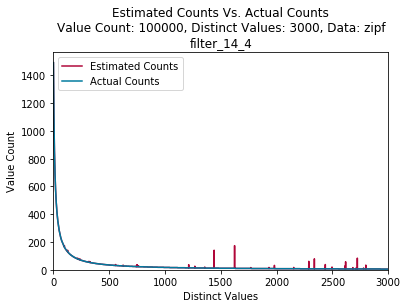

Estimation Technique: filter_14_4
Sample Size: 300000
Mean Error: 0.372413333333
Mean Squared Error: 94.1491666667
Column Size [kB](uint16_t): 200.0



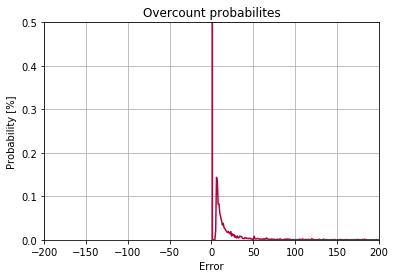

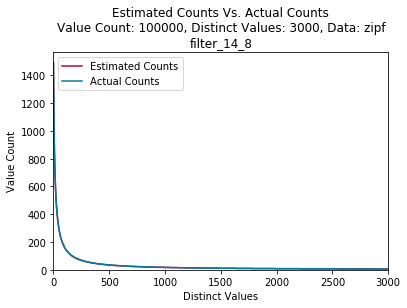

Estimation Technique: filter_14_8
Sample Size: 300000
Mean Error: 0.0327433333333
Mean Squared Error: 10.0195966667
Column Size [kB](uint16_t): 200.0



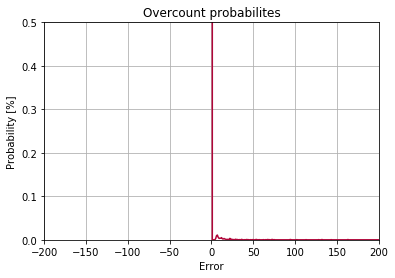

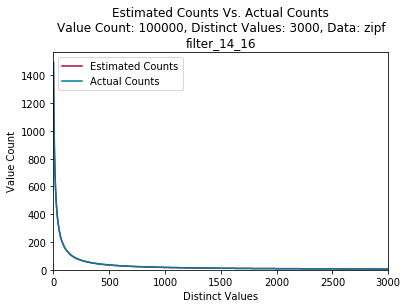

Estimation Technique: filter_14_16
Sample Size: 300000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



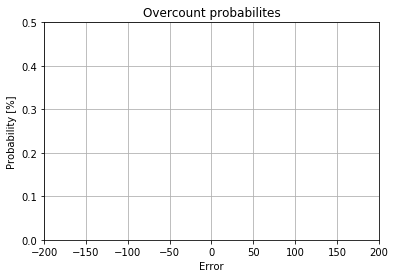

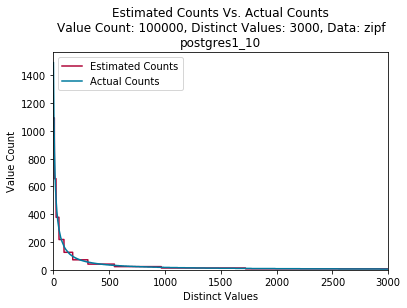

Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 4.59066666667
Mean Squared Error: 247.644666667
Column Size [kB](uint16_t): 200.0



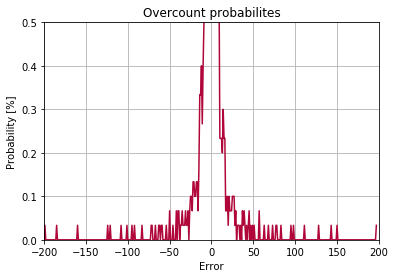

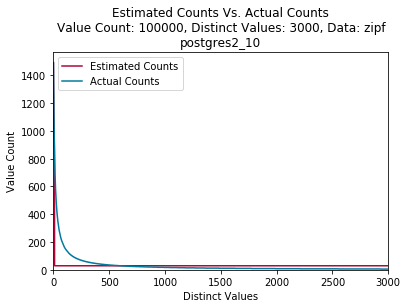

Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 28.3566666667
Mean Squared Error: 4099.66066667
Column Size [kB](uint16_t): 200.0



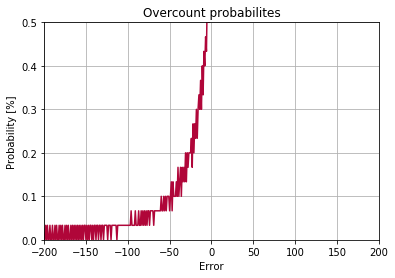

In [31]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14]
data_name = "zipf"
row_count = 100000
distinct_values = 3000

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
        estimation_example(data_name, row_count, distinct_values, estimation_tec)
        estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)
        
estimation_example(data_name, row_count, distinct_values, "postgres1_10")    
estimation_evaluation(data_name, row_count, distinct_values, "postgres1_10")

estimation_example(data_name, row_count, distinct_values, "postgres2_10")
estimation_evaluation(data_name, row_count, distinct_values, "postgres2_10")

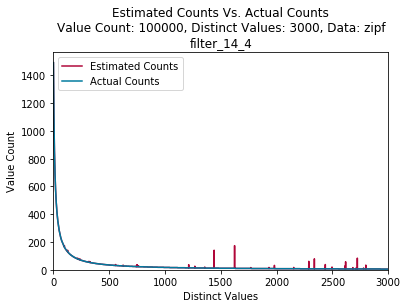

Estimation Technique: filter_14_4
Sample Size: 300000
Mean Error: 0.372413333333
Mean Squared Error: 94.1491666667
Column Size [kB](uint16_t): 200.0



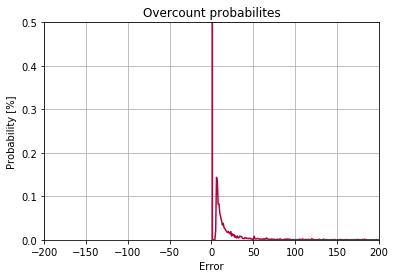

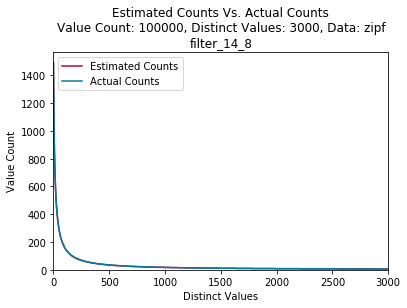

Estimation Technique: filter_14_8
Sample Size: 300000
Mean Error: 0.0327433333333
Mean Squared Error: 10.0195966667
Column Size [kB](uint16_t): 200.0



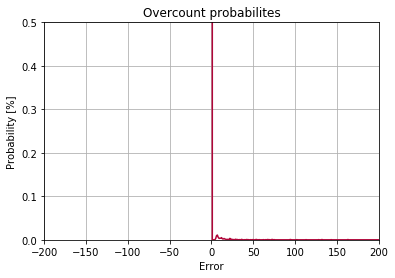

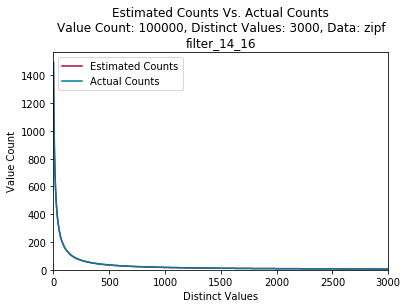

Estimation Technique: filter_14_16
Sample Size: 300000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



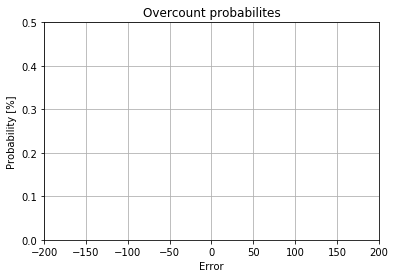

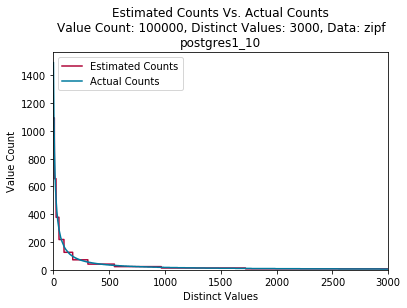

Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 4.59066666667
Mean Squared Error: 247.644666667
Column Size [kB](uint16_t): 200.0



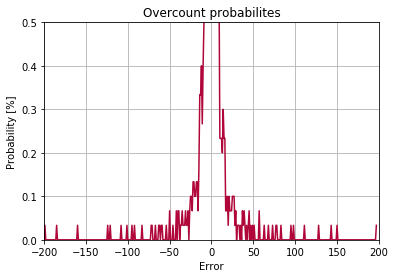

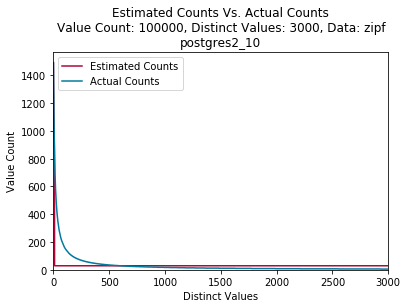

Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 28.3566666667
Mean Squared Error: 4099.66066667
Column Size [kB](uint16_t): 200.0



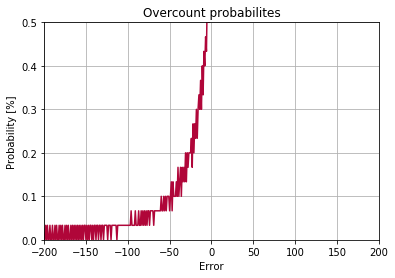

In [29]:
data = "normal"
distinct_values = 3000
row_count = 100000

estimation_example(data_name, row_count, distinct_values, "filter_14_4")  
estimation_evaluation(data_name, row_count, distinct_values, "filter_14_4")

estimation_example(data_name, row_count, distinct_values, "filter_14_8")  
estimation_evaluation(data_name, row_count, distinct_values, "filter_14_8")

estimation_example(data_name, row_count, distinct_values, "filter_14_16")  
estimation_evaluation(data_name, row_count, distinct_values, "filter_14_16")

estimation_example(data_name, row_count, distinct_values, "postgres1_10")  
estimation_evaluation(data_name, row_count, distinct_values, "postgres1_10")

estimation_example(data_name, row_count, distinct_values, "postgres2_10")  
estimation_evaluation(data_name, row_count, distinct_values, "postgres2_10")